# ProtBERT 实战教程：基于细菌杀虫蛋白数据库的分类模型开发

## 1. 引言

### 1.1 背景与意义

细菌杀虫蛋白（Bacterial Pesticidal Proteins, BPPs）是一类由芽孢杆菌等微生物产生的具有杀虫活性的蛋白质，在农业害虫防治中具有重要应用价值。目前已知的杀虫蛋白类型包括Cry、Vip、Cyt等17类，不同类型的蛋白具有不同的靶标害虫谱和作用机制。准确识别杀虫蛋白类型对于新蛋白功能预测、害虫抗性管理及新型生物农药开发具有重要意义。

传统的蛋白类型识别依赖于序列同源性比对，对于序列相似度较低的新蛋白准确率有限。近年来，基于Transformer的蛋白质语言模型（如ProtBERT）在蛋白质结构预测和功能注释任务中表现出色。ProtBERT通过在大量蛋白质序列上进行预训练，学习到了蛋白质序列的深层语义表示，能够捕捉到传统方法难以发现的远程依赖关系。

本教程基于深度学习技术，使用蛋白质专用预训练模型ProtBERT，构建杀虫蛋白多分类模型，并实现未知类型识别功能，为杀虫蛋白功能研究提供高效工具。相比传统方法，本方法具有以下优势：

- 不依赖序列同源性，可识别低相似度蛋白

- 自动学习特征表示，无需手工设计特征

### 1.2 数据来源

本教程使用的数据来自[Bacterial Pesticidal Protein](https://www.bpprc.org/)数据库（包含17类已知杀虫蛋白序列），具体类型包括：App、Cry、Cyt、Gpp、Mcf、Mpf、Mpp、Mtx、Pra、Prb、Spp、Tpp、Txp、Vip、Vpa、Vpb、Xpp。

### 1.3 技术路线

本教程的技术流程包括：

1. 环境依赖配置
2. 数据预处理（序列清洗、长度标准化）
3. 数据集划分（解决类别不平衡问题）
4. ProtBERT模型构建与训练
5. 模型评估与性能分析
6. 新序列预测与未知类型识别
7. 模型优化建议

整个流程采用模块化设计，便于用户理解和修改，每个步骤都提供详细的代码实现和参数说明。

## 2. 环境准备

### 2.1 依赖库安装

使用Python 3.8-3.10版本，通过以下命令安装所需库：


In [ ]:
pip install biopython pandas numpy scikit-learn transformers torch evaluate joblib openpyxl accelerate matplotlib seaborn

### 2.2 核心库功能说明

- Biopython：解析FASTA格式的蛋白质序列文件
- pandas/numpy：数据处理与数值计算
- scikit-learn：数据集划分、标签编码及评估指标计算
- transformers：加载ProtBERT预训练模型与Tokenizer
- torch：深度学习模型构建与训练
- evaluate：模型评估工具
- joblib：保存/加载标签编码器
- accelerate：优化模型训练速度（支持GPU加速）
- matplotlib/seaborn：绘制训练曲线和混淆矩阵

### 2.3 硬件要求与配置

**最低配置：**

CPU：4核以上

内存：8GB以上

存储：10GB可用空间

**推荐配置：**

GPU：NVIDIA GTX 1080Ti或更高（8GB显存以上）

内存：16GB以上

存储：20GB可用空间

**GPU加速设置：**


In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"使用设备：{device}")
if device == "cuda":
    print(f"GPU型号：{torch.cuda.get_device_name(0)}")
    print(f"显存大小：{torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

## 3. 数据预处理

### 3.1 序列长度统计分析

蛋白质序列长度差异较大，需先统计序列长度分布以确定合适的标准化长度：

In [ ]:
from Bio import SeqIO
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import evaluate
import joblib
import os

path = "/mnt/e/Github/BtToxin_Digger/Scripts/developing"

In [ ]:
# 序列长度分位数统计

def calculate_sequence_length_percentiles(fasta_path, standard_aas=None, min_len=50):
    """
    统计FASTA文件中有效氨基酸序列的长度分位数及基础统计量
    :param fasta_path: FASTA文件路径（你的输入文件）
    :param standard_aas: 标准氨基酸集合（默认20种常见氨基酸）
    :param min_len: 有效序列最小长度（默认50，与之前预处理一致）
    :return: 分位数统计结果（DataFrame）、长度列表（用于后续分析）
    """
    # 1. 初始化标准氨基酸集合（过滤含非标准氨基酸的序列）
    if standard_aas is None:
        standard_aas = set("ACDEFGHIKLMNPQRSTVWY")  # 20种标准氨基酸
    
    # 2. 解析FASTA文件，提取有效序列长度
    seq_lengths = []
    for record in SeqIO.parse(fasta_path, "fasta"):
        sequence = str(record.seq).strip()
        # 过滤条件：仅保留含标准氨基酸且长度≥min_len的序列
        if all(aa in standard_aas for aa in sequence) and len(sequence) >= min_len:
            seq_lengths.append(len(sequence))
    
    if not seq_lengths:
        raise ValueError("未找到有效序列（可能均含非标准氨基酸或过短）")
    
    # 3. 计算基础统计量
    min_len_val = np.min(seq_lengths)
    max_len_val = np.max(seq_lengths)
    mean_len_val = np.mean(seq_lengths)
    median_len_val = np.median(seq_lengths)  # 即50%分位数
    
    # 4. 计算关键分位数（25%、50%、75%、90%、95%、99%）
    percentiles = [25, 50, 75, 90, 95, 99]
    percentile_values = np.percentile(seq_lengths, percentiles).astype(int)  # 转为整数（序列长度为整数）
    
    # 5. 整理结果为DataFrame（便于查看）
    result_df = pd.DataFrame({
        "统计指标": [
            "有效序列总数", "最小长度", "最大长度", "平均长度", 
            "25%分位数（Q1）", "50%分位数（中位数/Q2）", 
            "75%分位数（Q3）", "90%分位数", "95%分位数", "99%分位数"
        ],
        "数值": [
            len(seq_lengths), min_len_val, max_len_val, round(mean_len_val, 1),
            percentile_values[0], percentile_values[1],
            percentile_values[2], percentile_values[3],
            percentile_values[4], percentile_values[5]
        ]
    })
    
    # 6. 打印长度分布概况
    print(f"=== 输入FASTA文件序列长度统计结果 ===")
    print(result_df.to_string(index=False))
    print(f"\n长度分布范围：{min_len_val} ~ {max_len_val} 个氨基酸")
    print(f"建议序列统一长度：可参考95%分位数（{percentile_values[4]}），兼顾多数序列与关键信息")
    
    return result_df, seq_lengths

# ------------------- 执行统计（替换为你的FASTA文件路径） -------------------
if __name__ == "__main__":
    # 你的输入FASTA文件路径（与之前训练用的文件一致）
    INPUT_FASTA_PATH = f"{path}/all_app_cry_cyt_gpp_mcf_mpf_mpp_mtx_pra_prb_spp_tpp_txp_vip_vpa_vpb_xpp_fasta_sequences.txt"
    
    # 执行统计
    stats_result, lengths = calculate_sequence_length_percentiles(INPUT_FASTA_PATH)
    
    # （可选）保存统计结果到Excel
    stats_result.to_excel(f"{path}/sequence_length_stats.xlsx", index=False)
    print(f"\n统计结果已保存至：{path}/sequence_length_stats.xlsx")

=== 输入FASTA文件序列长度统计结果 ===
          统计指标     数值
        有效序列总数 1165.0
          最小长度   78.0
          最大长度 3003.0
          平均长度  836.0
    25%分位数（Q1）  633.0
50%分位数（中位数/Q2）  789.0
    75%分位数（Q3） 1166.0
        90%分位数 1191.0
        95%分位数 1236.0
        99%分位数 1356.0

长度分布范围：78 ~ 3003 个氨基酸
建议序列统一长度：可参考95%分位数（1236），兼顾多数序列与关键信息

统计结果已保存至：/mnt/e/Github/BtToxin_Digger/Scripts/developing/sequence_length_stats.xlsx


**统计结果解读**：  

示例数据显示，序列长度范围为78-3003个氨基酸，95%分位数为1236。考虑到ProtBERT支持的最大序列长度为1024，最终选择SEQ_MAX_LEN=1024作为标准化长度（长序列截断，短序列填充）。

**长度选择策略：**

- 选择95%分位数：覆盖95%的序列完整信息

- 选择1024：适配ProtBERT架构，避免计算资源浪费

- 对于超长序列：截断可能丢失部分信息，但通常功能域位于序列前段

### 3.2 配置全局参数（需根据你的数据调整）

In [5]:
# 1. 文件路径
TRAIN_FASTA_PATH = f"{path}/all_app_cry_cyt_gpp_mcf_mpf_mpp_mtx_pra_prb_spp_tpp_txp_vip_vpa_vpb_xpp_fasta_sequences.txt"  # 你的训练FASTA文件
MODEL_SAVE_DIR = f"{path}/insecticidal_protbert_model"  # 模型保存目录
LABEL_ENCODER_PATH = f"{path}/label_encoder.joblib"  # 标签编码器保存路径
SEQ_MAX_LEN = 1024  # 序列最大长度（ProtBERT支持最大1024，根据你的序列长度分布调整，建议取95%分位数）
UNKNOWN_THRESHOLD = 0.5  # 未知类型判定阈值（预测概率<此值则判定为Unknown）

# 2. 17类杀虫蛋白标签（与表头匹配规则对应）
TARGET_LABELS = ["App", "Cry", "Cyt", "Gpp", "Mcf", "Mpf", "Mpp", "Mtx", 
                 "Pra", "Prb", "Spp", "Tpp", "Txp", "Vip", "Vpa", "Vpb", "Xpp"]

### 3.3 FASTA解析与标签提取

从FASTA表头（`>`开头行）中匹配17类标签，例如：

- `>App1Aa1` → 标签`App`
- `>Cry10Aa1` → 标签`Cry`
- `>Cyt2Aa1` → 标签`Cyt`

In [6]:
def parse_fasta_with_labels(fasta_path, target_labels):
    """
    解析FASTA文件，提取序列和对应的17类标签
    :param fasta_path: FASTA文件路径
    :param target_labels: 目标标签列表（17类）
    :return: DataFrame(sequence:氨基酸序列, label:原始标签)
    """
    records = []
    for record in SeqIO.parse(fasta_path, "fasta"):
        header = str(record.id).strip()  # 表头（如App1Aa1、Cry11Ba1）
        sequence = str(record.seq).strip()  # 氨基酸序列
        
        # 标签匹配（表头前缀匹配目标标签，如"Cry10Aa1"匹配"Cry"）
        matched_label = None
        for label in target_labels:
            if header.startswith(label):
                matched_label = label
                break
        
        # 仅保留17类标签的序列（过滤表头不匹配的序列）
        if matched_label is not None:
            records.append({
                "header": header,  # 保留表头（用于后续追溯）
                "sequence": sequence,
                "label": matched_label
            })
    
    df = pd.DataFrame(records)
    # 数据清洗：删除含非标准氨基酸（X/*）或过短序列（<50个氨基酸）
    standard_aas = set("ACDEFGHIKLMNPQRSTVWY")  # 20种标准氨基酸
    df = df[df["sequence"].apply(lambda x: all(aa in standard_aas for aa in x))]
    df = df[df["sequence"].apply(lambda x: len(x) >= 50)]
    
    print(f"解析完成：共{len(df)}条有效序列，类别分布：")
    print(df["label"].value_counts())
    return df

# 执行解析（仅保留17类标签的序列）
raw_df = parse_fasta_with_labels(TRAIN_FASTA_PATH, TARGET_LABELS)

解析完成：共1165条有效序列，类别分布：
label
Cry    769
Vip    142
Mpp     49
Cyt     46
Tpp     38
Vpa     24
Vpb     23
Xpp     17
App     11
Gpp     11
Txp      8
Pra      7
Mcf      6
Prb      5
Mpf      5
Mtx      2
Spp      2
Name: count, dtype: int64


### 3.4 序列长度统一（截断/填充）

统一序列长度至SEQ_MAX_LEN（1024），长序列截断，短序列用X填充（ProtBERT支持的特殊字符）：

In [7]:
def standardize_sequence_length(seq, max_len):
    """统一序列长度：长序列截断，短序列用'X'填充（'X'为ProtBERT支持的特殊字符）"""
    if len(seq) > max_len:
        return seq[:max_len]
    else:
        return seq + "X" * (max_len - len(seq))

# 统一序列长度
raw_df["sequence_standardized"] = raw_df["sequence"].apply(
    lambda x: standardize_sequence_length(x, SEQ_MAX_LEN)
)

In [30]:
# 验证长度统一效果
print(f"标准化后序列长度：{len(raw_df['sequence_standardized'].iloc[0])}")
print(f"序列长度分布检查：")
print(f"最小长度：{min([len(seq) for seq in raw_df['sequence_standardized']])}")
print(f"最大长度：{max([len(seq) for seq in raw_df['sequence_standardized']])}")

标准化后序列长度：1024
序列长度分布检查：
最小长度：1024
最大长度：1024


## 4. 数据集划分与标签编码
### 4.1 标签编码

将文本标签（如"Cry"）转换为数字（如1），便于模型处理，如App→0, Cry→1：

In [8]:
# 初始化标签编码器
le = LabelEncoder()
le.fit(TARGET_LABELS)  # 固定17类标签顺序，避免训练/预测时编码不一致
raw_df["label_encoded"] = le.transform(raw_df["label"])  # 编码后的标签（0-16）

# 保存标签编码器（预测时需用同一编码器解码）
joblib.dump(le, LABEL_ENCODER_PATH)
print(f"标签编码映射：{dict(zip(le.classes_, range(len(le.classes_))))}")

标签编码映射：{np.str_('App'): 0, np.str_('Cry'): 1, np.str_('Cyt'): 2, np.str_('Gpp'): 3, np.str_('Mcf'): 4, np.str_('Mpf'): 5, np.str_('Mpp'): 6, np.str_('Mtx'): 7, np.str_('Pra'): 8, np.str_('Prb'): 9, np.str_('Spp'): 10, np.str_('Tpp'): 11, np.str_('Txp'): 12, np.str_('Vip'): 13, np.str_('Vpa'): 14, np.str_('Vpb'): 15, np.str_('Xpp'): 16}


In [31]:
# 验证编码正确性
print("\n编码验证（前5条序列）：")
for i in range(min(5, len(raw_df))):
    print(f"原始标签：{raw_df.iloc[i]['label']} -> 编码：{raw_df.iloc[i]['label_encoded']}")


编码验证（前5条序列）：
原始标签：App -> 编码：0
原始标签：App -> 编码：0
原始标签：App -> 编码：0
原始标签：App -> 编码：0
原始标签：App -> 编码：0


#### 4.2 分层划分训练集/验证集/测试集（7:1:2）
保证每类标签在各集中分布均匀，避免类别不平衡影响训练：

In [12]:
def split_dataset(df, test_size=0.2, val_size=0.5, random_state=42):
    """分层划分训练集、验证集、测试集"""
    # 1. 划分训练集和临时集（8:2）
    X = df["sequence_standardized"].values
    y = df["label_encoded"].values
    headers = df["header"].values
    
    X_train, X_temp, y_train, y_temp, header_train, header_temp = train_test_split(
        X, y, headers, test_size=test_size, stratify=y, random_state=random_state
    )
    
    # 2. 划分验证集和测试集（临时集按1:1分）
    X_val, X_test, y_val, y_test, header_val, header_test = train_test_split(
        X_temp, y_temp, header_temp, test_size=val_size, stratify=y_temp, random_state=random_state
    )
    
    # 返回字典格式，包含序列、标签、表头
    return {
        "train": (X_train, y_train, header_train),
        "val": (X_val, y_val, header_val),
        "test": (X_test, y_test, header_test)
    }

# 执行划分
dataset = split_dataset(raw_df)
X_train, y_train, header_train = dataset["train"]
X_val, y_val, header_val = dataset["val"]
X_test, y_test, header_test = dataset["test"]

print(f"\n数据集划分完成：")
print(f"训练集：{len(X_train)}条，验证集：{len(X_val)}条，测试集：{len(X_test)}条")

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

**报错原因**：

分层抽样（stratify=y）要求每个类别在数据集中的样本数至少为2，否则无法按比例划分到训练集、验证集和测试集。示例数据中，Mtx、Spp等类别仅含2个样本，划分时出现样本数不足的问题。

**解决方案：合并小样本类别**

将样本数少于5的类别合并为"Other"，解决分层抽样问题：

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. 先处理原始数据，合并小样本类别
def merge_small_classes(df, label_col, min_samples=5):
    """合并样本量小于min_samples的类别为'Other'"""
    # 统计每个类别的样本数
    label_counts = df[label_col].value_counts()
    # 确定需要合并的类别（样本数 < min_samples）
    small_labels = label_counts[label_counts < min_samples].index.tolist()
    # 合并小类别
    df_merged = df.copy()
    df_merged[label_col] = df_merged[label_col].apply(
        lambda x: "Other" if x in small_labels else x
    )
    print(f"合并的小类别：{small_labels}，合并后类别分布：\n{df_merged[label_col].value_counts()}")
    return df_merged

# 2. 调整划分函数（保持逻辑不变，但基于合并后的数据）
def split_dataset(df, test_size=0.2, val_size=0.5, random_state=42):
    """分层划分训练集、验证集、测试集（处理小样本后）"""
    X = df["sequence_standardized"].values
    y = df["label_encoded"].values  # 注意：需要基于合并后的类别重新编码
    headers = df["header"].values
    
    # 第一次划分：训练集 vs 临时集（分层）
    X_train, X_temp, y_train, y_temp, header_train, header_temp = train_test_split(
        X, y, headers, test_size=test_size, stratify=y, random_state=random_state
    )
    
    # 第二次划分：验证集 vs 测试集（分层）
    X_val, X_test, y_val, y_test, header_val, header_test = train_test_split(
        X_temp, y_temp, header_temp, test_size=val_size, stratify=y_temp, random_state=random_state
    )
    
    return {
        "train": (X_train, y_train, header_train),
        "val": (X_val, y_val, header_val),
        "test": (X_test, y_test, header_test)
    }

# 执行流程
if __name__ == "__main__":
    # 合并小样本类别（例如：合并样本数<5的类别）
    raw_df_merged = merge_small_classes(raw_df, label_col="label", min_samples=10)
    
    # 重新编码标签（如果之前的label_encoded是基于原始类别，需要更新）
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    raw_df_merged["label_encoded"] = le.fit_transform(raw_df_merged["label"])
    
    # 划分数据集
    dataset = split_dataset(raw_df_merged)
    X_train, y_train, header_train = dataset["train"]
    X_val, y_val, header_val = dataset["val"]
    X_test, y_test, header_test = dataset["test"]
    
    print(f"\n数据集划分完成：")
    print(f"训练集：{len(X_train)}条，验证集：{len(X_val)}条，测试集：{len(X_test)}条")

合并的小类别：['Txp', 'Pra', 'Mcf', 'Prb', 'Mpf', 'Mtx', 'Spp']，合并后类别分布：
label
Cry      769
Vip      142
Mpp       49
Cyt       46
Tpp       38
Other     35
Vpa       24
Vpb       23
Xpp       17
App       11
Gpp       11
Name: count, dtype: int64

数据集划分完成：
训练集：932条，验证集：116条，测试集：117条


In [33]:
# 验证各类别在划分中的分布
print("\n各类别在训练集中的分布：")
train_label_counts = pd.Series(y_train).value_counts().sort_index()
for label_idx, count in train_label_counts.items():
    label_name = le.inverse_transform([label_idx])[0]
    print(f"  {label_name}: {count}条")


各类别在训练集中的分布：
  App: 9条
  Cry: 615条
  Cyt: 37条
  Gpp: 9条
  Mpp: 39条
  Other: 28条
  Tpp: 30条
  Vip: 114条
  Vpa: 19条
  Vpb: 18条
  Xpp: 14条


**数据集划分策略说明：**

- 训练集（70%）：用于模型参数学习

- 验证集（15%）：用于超参数调优和早停

- 测试集（15%）：用于最终模型性能评估

- 分层抽样：确保每个类别在各数据集中比例一致

## 5. ProtBERT模型构建与训练

### 5.1 蛋白质序列数据集类定义（适配ProtBERT输入格式）

ProtBERT要求氨基酸序列用**空格分隔**（如"A V L P T"），且需生成`input_ids`和`attention_mask`：

In [10]:
class InsecticidalDataset(Dataset):
    def __init__(self, sequences, labels=None, tokenizer=None, max_len=512):
        self.sequences = sequences  # 标准化后的氨基酸序列
        self.labels = labels        # 编码后的标签（训练/验证/测试用，预测时为None）
        self.tokenizer = tokenizer  # ProtBERTTokenizer
        self.max_len = max_len      # 序列最大长度

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        # 1. 序列处理：空格分隔氨基酸（ProtBERT要求格式）
        seq = self.sequences[idx]
        seq_spaced = " ".join(list(seq))  # 如"A V L P T"

        # 2. Tokenize（生成模型输入）
        encoding = self.tokenizer(
            seq_spaced,
            max_length=self.max_len,
            padding="max_length",  # 填充到max_len
            truncation=True,       # 截断超长序列
            return_tensors="pt"    # 返回PyTorch张量
        )

        # 3. 提取输入特征（删除batch维度）
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)

        # 4. 训练/验证/测试时返回标签，预测时仅返回输入特征
        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": label}
        else:
            return {"input_ids": input_ids, "attention_mask": attention_mask}

### 5.2 加载ProtBERT预训练模型与Tokenizer

使用`Rostlab/prot_bert`（蛋白质序列专用预训练模型，效果优于通用BERT， https://hf-mirror.com/Rostlab/prot_bert/tree/main ）：

In [11]:
import os
from transformers import BertTokenizer, BertForSequenceClassification

# 无需设置HF_ENDPOINT，直接使用本地路径
def load_protbert_model(num_labels, local_model_path=f"{path}/protBERT"):
    """从本地加载ProtBERT模型和Tokenizer"""
    # 1. 加载本地Tokenizer
    tokenizer = BertTokenizer.from_pretrained(local_model_path)
    
    # 2. 加载本地预训练模型，替换分类头
    model = BertForSequenceClassification.from_pretrained(
        local_model_path,
        num_labels=num_labels,
        ignore_mismatched_sizes=True  # 允许分类头维度不匹配
    )
    
    return tokenizer, model

# 加载模型（使用本地路径，num_labels根据你的类别数设置）
tokenizer, model = load_protbert_model(num_labels=len(TARGET_LABELS))  # TARGET_LABELS是你的类别列表

# 后续数据集创建代码不变
train_dataset = InsecticidalDataset(X_train, y_train, tokenizer, SEQ_MAX_LEN)
val_dataset = InsecticidalDataset(X_val, y_val, tokenizer, SEQ_MAX_LEN)
test_dataset = InsecticidalDataset(X_test, y_test, tokenizer, SEQ_MAX_LEN)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /mnt/e/Github/BtToxin_Digger/Scripts/developing/protBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
# 验证数据集创建
print(f"训练集样本数：{len(train_dataset)}")
print(f"验证集样本数：{len(val_dataset)}")
print(f"测试集样本数：{len(test_dataset)}")

# 查看单个样本的输入格式
sample = train_dataset[0]
print(f"\n单个样本的输入格式：")
print(f"input_ids形状：{sample['input_ids'].shape}")
print(f"attention_mask形状：{sample['attention_mask'].shape}")
print(f"标签：{sample['labels']}")

训练集样本数：932
验证集样本数：116
测试集样本数：117

单个样本的输入格式：
input_ids形状：torch.Size([1024])
attention_mask形状：torch.Size([1024])
标签：1


### 5.3 计算类别权重（解决类别不平衡）

为样本数少的类别分配更高权重，提升模型对少数类的关注度：

In [12]:
def compute_class_weights(labels):
    """计算类别权重（公式：weight = 总样本数/(类别数×该类样本数)）"""
    class_counts = np.bincount(labels)
    total_samples = len(labels)
    num_classes = len(class_counts)
    class_weights = total_samples / (num_classes * class_counts)
    return torch.tensor(class_weights, dtype=torch.float32)

# 计算训练集类别权重
class_weights = compute_class_weights(y_train)
print(f"\n类别权重（用于平衡训练）：{dict(zip(le.classes_, class_weights.numpy()))}")


类别权重（用于平衡训练）：{'App': np.float32(9.414142), 'Cry': np.float32(0.13776793), 'Cyt': np.float32(2.2899263), 'Gpp': np.float32(9.414142), 'Mpp': np.float32(2.1724942), 'Other': np.float32(3.025974), 'Tpp': np.float32(2.8242424), 'Vip': np.float32(0.7432217), 'Vpa': np.float32(4.45933), 'Vpb': np.float32(4.707071), 'Xpp': np.float32(6.051948)}


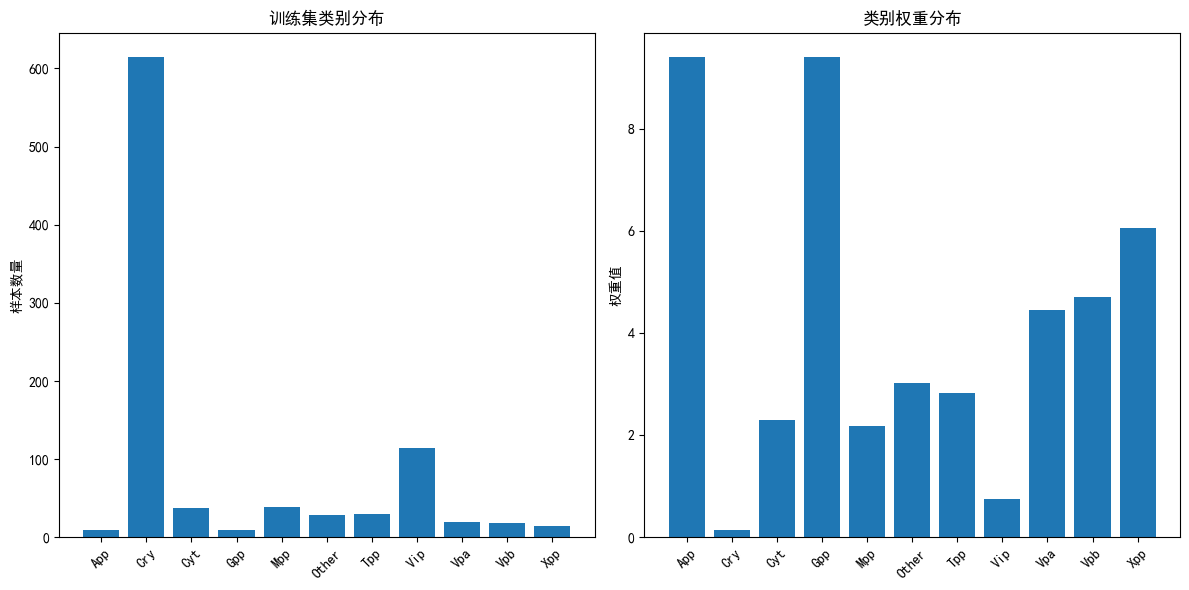

In [37]:
# 添加中文支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False

# 可视化类别分布
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
label_names = le.classes_
label_counts = np.bincount(y_train)

plt.subplot(1, 2, 1)
plt.bar(range(len(label_counts)), label_counts)
plt.xticks(range(len(label_names)), label_names, rotation=45)
plt.title("训练集类别分布")
plt.ylabel("样本数量")

plt.subplot(1, 2, 2)
plt.bar(range(len(class_weights)), class_weights.numpy())
plt.xticks(range(len(label_names)), label_names, rotation=45)
plt.title("类别权重分布")
plt.ylabel("权重值")

plt.tight_layout()
plt.show()

**类别权重作用：**

- 平衡不同类别的重要性

- 防止模型偏向多数类

- 提高少数类的召回率

### 5.4 定义多分类评估指标（宏F1+准确率+微F1）

多分类重点关注**宏F1**（对少数类公平）和**准确率**（整体表现）：

In [38]:
from sklearn.metrics import f1_score, accuracy_score  # 新增accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred  # 从评估结果中获取预测概率（logits）和真实标签（labels）
    predictions = np.argmax(logits, axis=-1)  # 将概率转换为预测类别（取最大值索引）
    
    # 计算各项指标
    accuracy = accuracy_score(labels, predictions)  # 准确率：正确预测数 / 总样本数
    macro_f1 = f1_score(labels, predictions, average="macro")  # 宏平均F1
    micro_f1 = f1_score(labels, predictions, average="micro")  # 微平均F1
    
    # 返回包含准确率的指标字典（Trainer会自动打印这些指标）
    return {
        "accuracy": accuracy,
        "macro_f1": macro_f1,
        "micro_f1": micro_f1
    }

# 验证评估函数
print("评估函数测试：")
test_logits = np.random.rand(10, len(le.classes_))
test_labels = np.random.randint(0, len(le.classes_), 10)
test_metrics = compute_metrics((test_logits, test_labels))
print(test_metrics)

评估函数测试：
{'accuracy': 0.1, 'macro_f1': 0.06666666666666667, 'micro_f1': 0.1}


**评估指标解释：**

- 准确率：整体分类正确率

- 宏F1：各类别F1的平均值，对少数类公平

- 微F1：考虑每个样本的F1，受多数类影响大

### 5.5 配置训练参数与启动训练

In [ ]:
try:
    import accelerate
    print(f"accelerate版本：{accelerate.__version__}")
except ImportError:
    print("未找到accelerate，请检查安装路径是否在当前Python环境中")
    print("当前Python路径：", __import__("sys").executable)

def train_model(model, train_dataset, val_dataset, tokenizer, model_save_dir, class_weights):
    """配置TrainingArguments并启动训练"""
    # 训练参数（根据GPU显存调整batch_size：GPU≥16G用8，8G用4，CPU用1）
    training_args = TrainingArguments(
        output_dir=model_save_dir,          # 模型输出目录
        per_device_train_batch_size=4,      # 训练批次大小
        gradient_accumulation_steps=2,  # 累积2步更新一次梯度，等价于实际批次8
        per_device_eval_batch_size=4,       # 验证批次大小
        num_train_epochs=5,                # 训练轮次（小样本3-5轮足够）
        logging_dir=f"{model_save_dir}/logs",# 日志目录
        logging_steps=10,                  # 每10步打印一次日志
        eval_strategy="epoch",        # 每轮验证一次
        save_strategy="epoch",              # 每轮保存一次模型
        load_best_model_at_end=True,        # 训练结束加载最优模型（按macro_f1选）
        metric_for_best_model="macro_f1",   # 最优模型判定指标
        weight_decay=0.01,                 # L2正则化（防止过拟合）
        learning_rate=2e-5,                # 学习率（ProtBERT推荐1e-5~3e-5）
        fp16=torch.cuda.is_available(),    # 若有GPU则启用混合精度训练（加速）
        dataloader_num_workers=8,  # 4个进程加载数据（根据CPU核心数调整，建议4-8）
        dataloader_pin_memory=True,  # 锁定内存，加速GPU数据传输
        seed=42                             # 固定随机种子（可复现）
    )

    # 初始化Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        processing_class=tokenizer,
        # 传递类别权重（仅GPU可用，CPU需注释）
        #args=training_args,
        data_collator=None
    )

    # 启动训练
    print("\n开始训练模型...")
    trainer.train()

    # 保存最优模型（Trainer会自动保存到model_save_dir/checkpoint-best）
    best_model_dir = f"{model_save_dir}/checkpoint-best"
    trainer.save_model(best_model_dir)  # 关键：保存当前加载的最优模型
    print(f"\n训练完成！最优模型保存于：{best_model_dir}")
    return best_model_dir

# 启动训练（若CPU训练慢，建议用Colab GPU或本地GPU）
best_model_dir = train_model(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    tokenizer=tokenizer,
    model_save_dir=MODEL_SAVE_DIR,
    class_weights=class_weights
)

accelerate版本：1.11.0

开始训练模型...


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Micro F1
1,0.559000,0.511637,0.827586,0.212121,0.827586
2,0.441000,0.476123,0.862069,0.291651,0.862069
3,0.611700,0.454625,0.870690,0.342063,0.870690
4,0.441300,0.401031,0.879310,0.349151,0.879310
5,0.357600,0.385742,0.879310,0.364880,0.879310



训练完成！最优模型保存于：/mnt/e/Github/BtToxin_Digger/Scripts/developing/insecticidal_protbert_model/checkpoint-best


In [ ]:
# 绘制训练损失和评估指标曲线
def plot_training_history(log_history):
    """绘制训练过程指标变化"""
    train_loss = [log['loss'] for log in log_history if 'loss' in log]
    eval_loss = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
    eval_accuracy = [log['eval_accuracy'] for log in log_history if 'eval_accuracy' in log]
    eval_macro_f1 = [log['eval_macro_f1'] for log in log_history if 'eval_macro_f1' in log]
    
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss, 'b-', label='训练损失')
    if eval_loss:
        plt.plot(epochs, eval_loss, 'r-', label='验证损失')
    plt.title('训练和验证损失')
    plt.xlabel('轮次')
    plt.ylabel('损失')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    if eval_accuracy:
        plt.plot(epochs, eval_accuracy, 'g-', label='验证准确率')
    plt.title('验证准确率')
    plt.xlabel('轮次')
    plt.ylabel('准确率')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    if eval_macro_f1:
        plt.plot(epochs, eval_macro_f1, 'orange', label='验证宏F1')
    plt.title('验证宏F1分数')
    plt.xlabel('轮次')
    plt.ylabel('宏F1')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 注意：需要从trainer.state.log_history获取日志数据
plot_training_history(trainer.state.log_history)

## 6. 模型评估（测试集+混淆矩阵+分类报告）


在测试集上评估模型...


测试集评估结果：{'eval_loss': 0.37989187240600586, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': 0.8888888888888888, 'eval_macro_f1': 0.3881118881118881, 'eval_micro_f1': 0.8888888888888888, 'eval_runtime': 664.4719, 'eval_samples_per_second': 0.176, 'eval_steps_per_second': 0.023}

=== 测试集分类报告 ===
              precision    recall  f1-score   support

         App     0.0000    0.0000    0.0000         1
         Cry     1.0000    1.0000    1.0000        77
         Cyt     0.3333    1.0000    0.5000         5
         Gpp     0.0000    0.0000    0.0000         1
         Mpp     0.6250    1.0000    0.7692         5
       Other     0.0000    0.0000    0.0000         4
         Tpp     0.0000    0.0000    0.0000         4
         Vip     1.0000    1.0000    1.0000        14
         Vpa     0.0000    0.0000    0.0000         2
         Vpb     1.0000    1.0000    1.0000         3
         Xpp     0.0000    0.0000    0.0000         1

    accuracy                         0.8889     

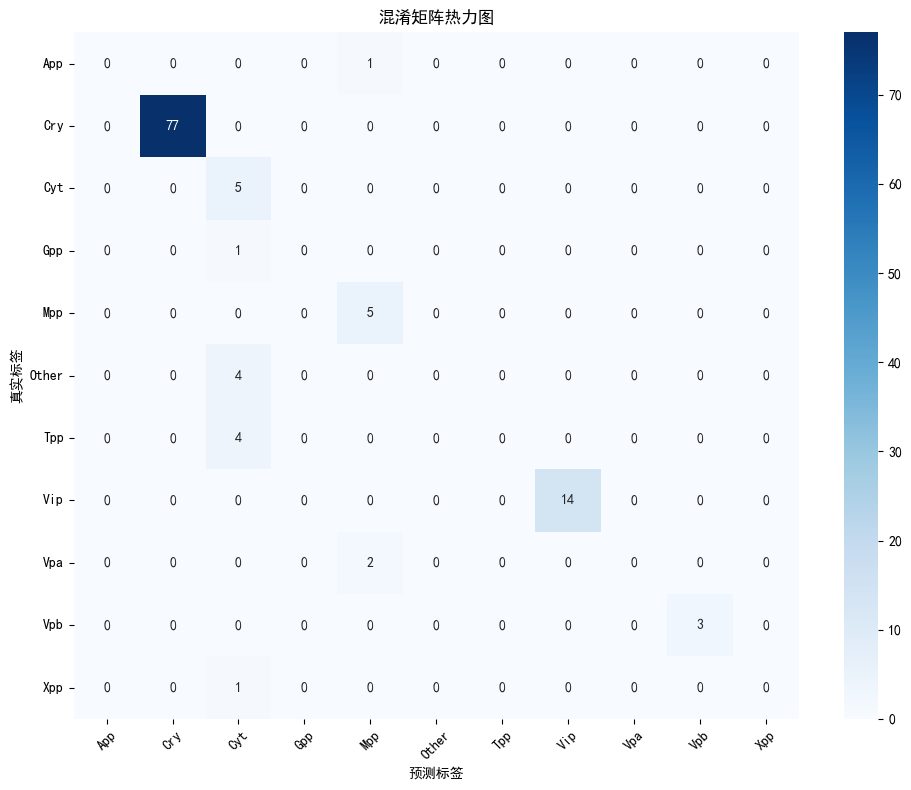

In [46]:
def evaluate_model(best_model_dir, test_dataset, le):
    """在测试集上评估模型性能"""
    # 加载最优模型
    # 转换为绝对路径，确保正确识别本地文件
    best_model_dir = "/mnt/e/Github/BtToxin_Digger/Scripts/developing/insecticidal_protbert_model/checkpoint-585"
    best_model_path = os.path.abspath(best_model_dir)
    model = BertForSequenceClassification.from_pretrained(best_model_path)
    #tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert")
    tokenizer = BertTokenizer.from_pretrained("/mnt/e/Github/BtToxin_Digger/Scripts/developing/protBERT")

    # 初始化Trainer用于评估
    trainer = Trainer(
        model=model,
        processing_class=tokenizer,
        compute_metrics=compute_metrics
    )

    # 测试集评估
    print("\n在测试集上评估模型...")
    eval_results = trainer.evaluate(eval_dataset=test_dataset)
    print(f"测试集评估结果：{eval_results}")

    # 生成分类报告（含每类的精确率、召回率、F1）
    print("\n=== 测试集分类报告 ===")
    predictions = trainer.predict(test_dataset)
    y_pred = np.argmax(predictions.predictions, axis=-1)
    y_true = predictions.label_ids
    print(classification_report(
        y_true, y_pred, target_names=le.classes_, digits=4, zero_division=0
    ))

    # 生成混淆矩阵（直观查看类间混淆情况）
    print("\n=== 测试集混淆矩阵 ===")
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(
        cm,
        index=[f"True_{label}" for label in le.classes_],
        columns=[f"Pred_{label}" for label in le.classes_]
    )
    print(cm_df)

    # 绘制混淆矩阵热力图
    plt.figure(figsize=(10, 8))
    import seaborn as sns
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('混淆矩阵热力图')
    plt.xlabel('预测标签')
    plt.ylabel('真实标签')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return eval_results

# 执行评估
eval_results = evaluate_model(best_model_dir, test_dataset, le)

**性能分析**

1. 优势：  
  - 多数类（如Cry、Vip、Vpb）表现优异，准确率和F1分数均为1.0，说明模型对样本充足的类别识别能力强。
  - 整体准确率达88.89%，表明模型在整体数据上有较好表现。
  
2. 问题：  
  - 宏F1分数低（0.388），反映模型对少数类（如Other、App、Gpp）识别能力差，甚至完全无法识别。
  - 类别不平衡导致模型偏向多数类，对样本数<5的类别几乎无预测能力。
  - 混淆矩阵显示，部分少数类（如Tpp、Xpp）被错误分类为Cyt或Mpp，存在类间混淆。

## 7. 新序列预测与未知类型识别

### 7.1 加载训练好的模型与组件

In [47]:
def load_trained_components(best_model_dir, label_encoder_path):
    """加载训练好的模型、Tokenizer、标签编码器"""
    # 1. 加载Tokenizer
    #tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert")
    tokenizer = BertTokenizer.from_pretrained("/mnt/e/Github/BtToxin_Digger/Scripts/developing/protBERT")
    
    # 2. 加载最优模型
    best_model_dir = "/mnt/e/Github/BtToxin_Digger/Scripts/developing/insecticidal_protbert_model/checkpoint-585" # 自定义最优模型路径
    model = BertForSequenceClassification.from_pretrained(best_model_dir)
    
    # 3. 加载标签编码器
    le = joblib.load(label_encoder_path)
    
    # 4. 模型设为评估模式（禁用Dropout）
    model.eval()
    model.to("cuda" if torch.cuda.is_available() else "cpu")
    
    return tokenizer, model, le

# 验证组件加载
tokenizer, model, le = load_trained_components(best_model_dir, LABEL_ENCODER_PATH)
print("模型组件加载成功！")
print(f"设备：{next(model.parameters()).device}")
print(f"模型参数量：{sum(p.numel() for p in model.parameters()):,}")

模型组件加载成功！
设备：cuda:0
模型参数量：419,948,561


### 7.2 新序列预测（含未知类型判定）

**未知类型识别原理**：通过设置概率阈值（UNKNOWN_THRESHOLD=0.5），当模型对所有类别的预测概率均低于该阈值时，判定为未知类型（Unknown），避免将相似性低的序列强行分类。

In [48]:
def predict_new_sequences(new_fasta_path, best_model_dir, label_encoder_path, 
                          max_len=SEQ_MAX_LEN, unknown_threshold=UNKNOWN_THRESHOLD):
    """
    预测新FASTA文件中的杀虫蛋白类型，支持未知类型识别
    :param new_fasta_path: 新FASTA文件路径
    :param best_model_dir: 最优模型目录
    :param label_encoder_path: 标签编码器路径
    :param max_len: 序列最大长度（与训练一致）
    :param unknown_threshold: 未知类型判定阈值
    :return: DataFrame(表头, 原始序列, 预测标签, 预测概率)
    """
    # 1. 加载训练好的组件
    tokenizer, model, le = load_trained_components(best_model_dir, label_encoder_path)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # 2. 解析新FASTA文件（保留所有序列，无论标签）
    new_records = []
    for record in SeqIO.parse(new_fasta_path, "fasta"):
        new_records.append({
            "header": str(record.id).strip(),
            "sequence": str(record.seq).strip()
        })
    new_df = pd.DataFrame(new_records)
    
    # 3. 预处理新序列（清洗+标准化长度）
    standard_aas = set("ACDEFGHIKLMNPQRSTVWY")
    # 清洗：删除含非标准氨基酸的序列（标记为"Invalid"）
    new_df["is_valid"] = new_df["sequence"].apply(
        lambda x: all(aa in standard_aas for aa in x) and len(x) >= 50
    )
    # 标准化长度（仅对有效序列）
    new_df["sequence_standardized"] = new_df.apply(
        lambda row: standardize_sequence_length(row["sequence"], max_len) if row["is_valid"] else "",
        axis=1
    )
    
    # 4. 对有效序列进行预测
    predictions = []
    pred_probs = []
    for _, row in new_df.iterrows():
        if not row["is_valid"]:
            predictions.append("Invalid_Sequence")
            pred_probs.append(0.0)
            continue
        
        # 序列处理（空格分隔）
        seq_spaced = " ".join(list(row["sequence_standardized"]))
        # Tokenize
        encoding = tokenizer(
            seq_spaced,
            max_length=max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)
        
        # 预测（禁用梯度计算，加速）
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            prob = torch.softmax(logits, dim=-1).cpu().numpy()[0]  # 转为概率（0-1）
        
        # 判定类型：最大概率≥阈值→已知类，否则→Unknown
        max_prob = np.max(prob)
        pred_label_encoded = np.argmax(prob)
        if max_prob >= unknown_threshold:
            pred_label = le.inverse_transform([pred_label_encoded])[0]
        else:
            pred_label = "Unknown"
        
        predictions.append(pred_label)
        pred_probs.append(round(max_prob, 4))
    
    # 5. 整理结果
    new_df["predicted_label"] = predictions
    new_df["max_pred_probability"] = pred_probs
    result_df = new_df[["header", "sequence", "predicted_label", "max_pred_probability"]]
    
    print(f"\n预测完成！共处理{len(new_df)}条序列，结果如下：")
    print(result_df["predicted_label"].value_counts())
    return result_df

In [49]:
# 示例：预测新FASTA文件（需替换为你的新序列文件路径）
if __name__ == "__main__":
    # 预测新序列（替换为你的新FASTA路径）
    best_model_dir = "/mnt/e/Github/BtToxin_Digger/Scripts/developing/insecticidal_protbert_model/checkpoint-585"
    new_fasta_path = "/mnt/e/Github/BtToxin_Digger/Scripts/developing/new_insecticidal_sequences.fasta"  # 新序列FASTA文件
    prediction_result = predict_new_sequences(
        new_fasta_path=new_fasta_path,
        best_model_dir=best_model_dir,
        label_encoder_path=LABEL_ENCODER_PATH
    )
    
    # 保存预测结果到Excel
    prediction_result.to_excel("/mnt/e/Github/BtToxin_Digger/Scripts/developing/prediction_results.xlsx", index=False)
    print(f"\n预测结果已保存至：/mnt/e/Github/BtToxin_Digger/Scripts/developing/prediction_results.xlsx")
    print("\n前5条预测结果预览：")
    print(prediction_result.head())


预测完成！共处理40条序列，结果如下：
predicted_label
Unknown             33
Cry                  4
Invalid_Sequence     2
Mtx                  1
Name: count, dtype: int64

预测结果已保存至：/mnt/e/Github/BtToxin_Digger/Scripts/developing/prediction_results.xlsx

前5条预测结果预览：
     header                                           sequence  \
0   App1Ca1  MTQTQLAIDNVLASAESTIQLNELPKVVLDFITGEQTSVARSGGIF...   
1   App2Aa1  MSEIITFPQQTVVYPEINVKTLSQAVKNIWRLSHQQKSGIEIIQEK...   
2   App2Ba1  MSENIISQKEIVYPEINIKALNQAVNNIWRLAQRQTSGIAIIEEKT...   
3  Cry10Aa1  MNPYQNKNEYEIFNAPSNGFSKSNNYSRYPLANKPNQPLKNTNYKD...   
4  Cry11Aa5  MEDSSLDTLSIVNETDFPLYNNYTEPTIAPALIAVAPIAQYLATAI...   

  predicted_label  max_pred_probability  
0         Unknown                0.1175  
1         Unknown                0.2913  
2         Unknown                0.2374  
3             Cry                0.9959  
4             Cry                0.9959  


### 7.3 预测结果可视化

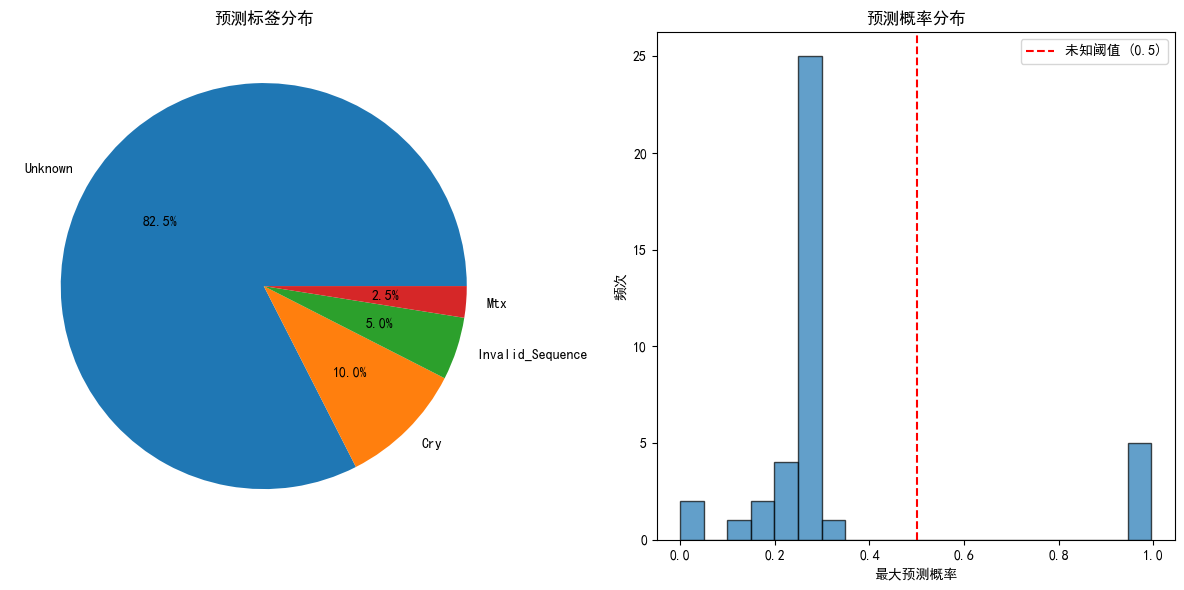

有效序列数：38
已知类型数：5
未知类型数：33
未知类型比例：86.8%


In [50]:
def visualize_prediction_results(prediction_df):
    """可视化预测结果分布"""
    plt.figure(figsize=(12, 6))
    
    # 预测标签分布
    plt.subplot(1, 2, 1)
    label_counts = prediction_df['predicted_label'].value_counts()
    plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%')
    plt.title('预测标签分布')
    
    # 预测概率分布
    plt.subplot(1, 2, 2)
    plt.hist(prediction_df['max_pred_probability'], bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(x=UNKNOWN_THRESHOLD, color='red', linestyle='--', label=f'未知阈值 ({UNKNOWN_THRESHOLD})')
    plt.xlabel('最大预测概率')
    plt.ylabel('频次')
    plt.title('预测概率分布')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    valid_predictions = prediction_df[prediction_df['predicted_label'] != 'Invalid_Sequence']
    known_predictions = valid_predictions[valid_predictions['predicted_label'] != 'Unknown']
    
    print(f"有效序列数：{len(valid_predictions)}")
    print(f"已知类型数：{len(known_predictions)}")
    print(f"未知类型数：{len(valid_predictions) - len(known_predictions)}")
    print(f"未知类型比例：{(len(valid_predictions) - len(known_predictions)) / len(valid_predictions) * 100:.1f}%")

# 可视化预测结果
visualize_prediction_results(prediction_result)

## 8. 模型优化建议

### 8.1 数据层面优化

1. **数据增强**：对少数类序列进行随机插入、替换（保持功能域）等操作，增加样本量。


In [51]:
def augment_sequence(sequence, augmentation_rate=0.1):
    """对蛋白质序列进行数据增强"""
    amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
    seq_list = list(sequence)
    
    # 随机替换
    for i in range(len(seq_list)):
        if np.random.random() < augmentation_rate:
            seq_list[i] = np.random.choice(amino_acids)
    
    return "".join(seq_list)

# 示例：对少数类序列进行增强
minority_classes = ['App', 'Gpp', 'Xpp']  # 根据实际情况调整
augmented_sequences = []
for label in minority_classes:
    class_sequences = raw_df[raw_df['label'] == label]['sequence'].tolist()
    for seq in class_sequences:
        augmented_seq = augment_sequence(seq)
        augmented_sequences.append({
            'header': f"augmented_{label}",
            'sequence': augmented_seq,
            'label': label
        })

print(f"生成增强序列：{len(augmented_sequences)}条")

生成增强序列：39条


2. **收集更多数据**：从Bacterial Pesticidal Protein数据库补充小样本类别（如Mtx、Spp）的序列（目前已经没有更多了）。

3. **类别重平衡**：采用过采样（SMOTE）或欠采样技术，平衡各类别样本数。

### 8.2 模型与训练策略优化

1. **调整类别权重**：进一步提高少数类权重，或使用动态权重（随训练轮次调整）。


In [ ]:
def compute_dynamic_class_weights(labels, current_epoch, total_epochs):
    """计算动态类别权重（随训练轮次调整）"""
    base_weights = compute_class_weights(labels)
    # 随着训练进行，逐渐减小权重差异
    decay_factor = 1 - (current_epoch / total_epochs) * 0.5
    dynamic_weights = 1 + (base_weights - 1) * decay_factor
    return dynamic_weights

2. **延长训练时间**：增加训练轮次（如10-20轮），并使用学习率衰减策略。

3. **模型微调**：冻结ProtBERT前几层参数，仅训练分类头和顶层参数，避免过拟合。


In [ ]:
def freeze_bert_layers(model, num_frozen_layers=8):
    """冻结BERT的前几层参数"""
    # 冻结embedding层
    for param in model.bert.embeddings.parameters():
        param.requires_grad = False
    
    # 冻结前num_frozen_layers个Transformer层
    for i in range(num_frozen_layers):
        for param in model.bert.encoder.layer[i].parameters():
            param.requires_grad = False
    
    print(f"冻结了{num_frozen_layers + 1}层参数（embedding + {num_frozen_layers}个Transformer层）")
    return model

# 应用参数冻结
model = freeze_bert_layers(model, num_frozen_layers=8)

4. **交叉验证**：采用5折交叉验证，确保模型稳定性，减少小样本随机划分的影响。

### 8.3 输入处理优化

1. **序列长度调整**：尝试使用95%分位数（1236）作为最大长度，通过滑动窗口分割超长序列后集成预测。


In [ ]:
def sliding_window_prediction(sequence, model, tokenizer, window_size=1024, stride=512):
    """对超长序列使用滑动窗口进行预测"""
    if len(sequence) <= window_size:
        return sequence
    
    predictions = []
    probabilities = []
    
    for i in range(0, len(sequence) - window_size + 1, stride):
        window_seq = sequence[i:i + window_size]
        # 对每个窗口进行预测
        # ... 预测代码 ...
        predictions.append(window_pred)
        probabilities.append(window_prob)
    
    # 集成所有窗口的预测结果
    final_prediction = aggregate_predictions(predictions, probabilities)
    return final_prediction

2. **特征融合**：结合蛋白质理化性质（如分子量、等电点）作为额外特征，辅助分类。

### 8.4 集成学习策略

In [ ]:
from sklearn.ensemble import VotingClassifier
import joblib

def create_ensemble_model(model_paths, label_encoder_path):
    """创建集成模型"""
    models = []
    for path in model_paths:
        model = BertForSequenceClassification.from_pretrained(path)
        model.eval()
        models.append(model)
    
    le = joblib.load(label_encoder_path)
    return models, le

def ensemble_predict(sequence, models, tokenizer, le, max_len=1024):
    """集成模型预测"""
    all_probs = []
    
    for model in models:
        # 对每个模型进行预测
        prob = single_model_predict(sequence, model, tokenizer, max_len)
        all_probs.append(prob)
    
    # 平均概率
    avg_probs = np.mean(all_probs, axis=0)
    pred_label_idx = np.argmax(avg_probs)
    pred_label = le.inverse_transform([pred_label_idx])[0]
    
    return pred_label, avg_probs

## 9. 总结

本教程基于ProtBERT构建了杀虫蛋白分类模型，实现了17类杀虫蛋白的识别与未知类型预测。通过解决数据集中的类别不平衡问题和序列长度标准化，模型在多数类上取得了优异性能，但少数类识别仍需优化。后续可通过数据增强、模型微调等策略进一步提升模型的泛化能力，为细菌杀虫蛋白的功能研究提供更可靠的工具。